In [1]:
import pandas as pd
import numpy as np
import torch
import ast
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

In [2]:
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
bert_tokenizer.save_vocabulary('.')

tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
tokenizer.enable_padding()

c:\Users\hardi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_df_kesehatan = pd.read_csv(r'../Dropout Batch 32 p 0.2/train_df_kesehatan.csv')
val_df_kesehatan = pd.read_csv(r'../Dropout Batch 32 p 0.2/val_df_kesehatan.csv')
test_df_kesehatan= pd.read_csv(r'../Dropout Batch 32 p 0.2/test_df_kesehatan.csv')

In [4]:
print(train_df_kesehatan.shape)
print(val_df_kesehatan.shape)
print(test_df_kesehatan.shape)

(1542, 5)
(309, 5)
(206, 5)


## Proses Pemodelan

In [5]:
from transformers import BertModel

# Load pre-trained IndoBERT model
model_name = 'indobenchmark/indobert-base-p1'
indobert_model = BertModel.from_pretrained(model_name)

for param in indobert_model.parameters():
    param.requires_grad = False

c:\Users\hardi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


### Data Loader untuk LSTM

In [6]:
def change_data_to_tensor(dataframe, max_seq_length, batch_size=64):
    # # Calculate the maximum sequence lengths
    # max_len_input_ids = max(dataframe['Input_IDs'].apply(len))
    # max_len_attention_mask = max(dataframe['Attention Mask'].apply(len))

    # Function to pad sequences
    def pad_sequence(seq, max_len):
        return seq[:max_len] + [0] * (max_len - len(seq[:max_len]))
    
    dataframe['Input_IDs'] = dataframe['Input_IDs'].apply(ast.literal_eval)
    dataframe['Attention Mask'] = dataframe['Attention Mask'].apply(ast.literal_eval)

    # Apply padding to Input_IDs and Attention Mask
    input_ids = dataframe['Input_IDs'].apply(lambda x: pad_sequence(x, max_seq_length)).values
    attention_mask = dataframe['Attention Mask'].apply(lambda x: pad_sequence(x, max_seq_length)).values

    # Convert to numpy arrays
    input_ids = np.array(list(input_ids))
    attention_mask = np.array(list(attention_mask))

    # Convert to PyTorch tensors
    input_ids_tensor = torch.tensor(input_ids, dtype=torch.long)
    attention_mask_tensor = torch.tensor(attention_mask, dtype=torch.long)
    labels_tensor = torch.tensor(dataframe['Klasifikasi Berita'].values.reshape(-1, 1), dtype=torch.long)

    # Create TensorDataset and DataLoader
    dataset = TensorDataset(input_ids_tensor, attention_mask_tensor, labels_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return data_loader

In [7]:
train_loader_Kesehatan = change_data_to_tensor(train_df_kesehatan, 512)
val_loader_Kesehatan = change_data_to_tensor(val_df_kesehatan, 512)
test_loader_Kesehatan = change_data_to_tensor(test_df_kesehatan, 512)

In [8]:
# Periksa satu batch dari train_loader
for batch in train_loader_Kesehatan:
    input_ids, attention_mask, labels = batch
    print("Input IDs shape:", input_ids.shape)
    print("Attention Mask shape:", attention_mask.shape)
    print("Labels shape:", labels.shape)
    break  # Cukup periksa satu batch pertama

Input IDs shape: torch.Size([64, 512])
Attention Mask shape: torch.Size([64, 512])
Labels shape: torch.Size([64, 1])


In [9]:
# Periksa satu batch dari val_loader
for batch in val_loader_Kesehatan:
    input_ids, attention_mask, labels = batch
    print("Input IDs shape:", input_ids.shape)
    print("Attention Mask shape:", attention_mask.shape)
    print("Labels shape:", labels.shape)
    break

Input IDs shape: torch.Size([64, 512])
Attention Mask shape: torch.Size([64, 512])
Labels shape: torch.Size([64, 1])


In [10]:
# Periksa satu batch dari val_loader
for batch in test_loader_Kesehatan:
    input_ids, attention_mask, labels = batch
    print("Input IDs shape:", input_ids.shape)
    print("Attention Mask shape:", attention_mask.shape)
    print("Labels shape:", labels.shape)
    break

Input IDs shape: torch.Size([64, 512])
Attention Mask shape: torch.Size([64, 512])
Labels shape: torch.Size([64, 1])


### Bangun Model LSTM

In [11]:
# Definisikan model LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, fc_hidden_sizes, output_size, dropout_prob=0.2):
        super(LSTMClassifier, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size

        # LSTM layer
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, num_layers=1, batch_first=True)

        # Fully connected layers
        layer_sizes = [lstm_hidden_size] + fc_hidden_sizes
        print(layer_sizes)
        fc_layers = []

        fc_layers.append(nn.Linear(layer_sizes[0], layer_sizes[1]))
        fc_layers.append(nn.BatchNorm1d(layer_sizes[1]))
        fc_layers.append(nn.Dropout(dropout_prob))
        fc_layers.append(nn.ReLU())

        for i in range(1, len(fc_hidden_sizes)):
            fc_layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            fc_layers.append(nn.ReLU())

        self.fc = nn.Sequential(*fc_layers)

        # Output layer
        self.output_layer = nn.Linear(fc_hidden_sizes[-1], output_size)

    def forward(self, input_ids):
        lstm_out, _ = self.lstm(input_ids)

        # Only take the output from the last timestep
        lstm_out = lstm_out[:, -1, :]
        # print(f"Shape dari lstm_out setelah LSTM: {lstm_out.shape}")

        # Feedforward through fully connected layers
        fc_out = self.fc(lstm_out)
        # print(f"Shape dari fc_out setelah fully connected layers: {fc_out.shape}")

        # Feedforward through output layer
        logits = self.output_layer(fc_out)

        return logits

# Dimensi input untuk LSTM
input_size = indobert_model.config.hidden_size
hidden_size = 768  # Sesuaikan dengan kebutuhan Anda
fc_hidden_sizes = [128, 32, 32]
output_size = 2  # Jumlah kelas (hoax dan non-hoax)

# Inisialisasi model LSTM
lstm_model = LSTMClassifier(input_size, hidden_size, fc_hidden_sizes, output_size)

# Cetak ringkasan model
print(lstm_model)

[768, 128, 32, 32]
LSTMClassifier(
  (lstm): LSTM(768, 768, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
  )
  (output_layer): Linear(in_features=32, out_features=2, bias=True)
)


### Gabung IndoBERT & LSTM

In [12]:
# Definisikan model gabungan
class IndoBERT_LSTM(nn.Module):
    def __init__(self, indobert_model, lstm_model):
        super(IndoBERT_LSTM, self).__init__()
        self.indobert = indobert_model
        self.lstm = lstm_model

    def forward(self, input_ids, attention_mask):
        # Forward pass through IndoBERT
        with torch.no_grad():
            outputs = self.indobert(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden_state = outputs[0]

        # # Debugging shape of last_hidden_state
        # print(f"last_hidden_state shape: {last_hidden_state.shape}")  # Should be [batch_size, seq_len, hidden_size]

        # Forward pass through LSTMClassifier
        logits = self.lstm(last_hidden_state)

        return logits

# Inisialisasi model gabungan
model = IndoBERT_LSTM(indobert_model, lstm_model)
print(model)

IndoBERT_LSTM(
  (indobert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [13]:
def evaluate_model(results, tokenizer, name_file):
    val_texts = results['val_texts']
    val_predicted_labels = np.array(results['val_predicted_labels'])
    val_true_labels = np.array(results['val_true_labels'])

    # Hitung metrik evaluasi
    accuracy = accuracy_score(val_true_labels, val_predicted_labels)
    precision = precision_score(val_true_labels, val_predicted_labels)
    recall = recall_score(val_true_labels, val_predicted_labels)
    f1 = f1_score(val_true_labels, val_predicted_labels)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')

    # Confusion Matrix
    cm = confusion_matrix(val_true_labels, val_predicted_labels)
    tick_labels = ['Non-Hoax', 'Hoax']
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tick_labels, yticklabels=tick_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Identifikasi False Negatives (FN) dan False Positives (FP)
    false_negatives = []
    false_positives = []

    for i in range(len(val_texts)):
        if val_true_labels[i] == 1 and val_predicted_labels[i] == 0:
            false_negatives.append(val_texts[i])  # Hoax (1) predicted as Non-Hoax (0)
        elif val_true_labels[i] == 0 and val_predicted_labels[i] == 1:
            false_positives.append(val_texts[i])  # Non-Hoax (0) predicted as Hoax (1)

    # Dekode token kembali ke teks
    decoded_fn_texts = [tokenizer.decode(tokens, skip_special_tokens=True) for tokens in false_negatives]
    decoded_fp_texts = [tokenizer.decode(tokens, skip_special_tokens=True) for tokens in false_positives]

    # Simpan hasil FN dan FP ke dalam file CSV dengan label yang sesuai
    fn_df = pd.DataFrame(decoded_fn_texts, columns=['Text'])
    fn_df['True Label'] = 'hoax'
    fn_df['Predicted Label'] = 'non-hoax'

    fp_df = pd.DataFrame(decoded_fp_texts, columns=['Text'])
    fp_df['True Label'] = 'non-hoax'
    fp_df['Predicted Label'] = 'hoax'

    # Simpan ke CSV
    fn_df.to_csv(f'false_negatives_{name_file}.csv', index=False)
    fp_df.to_csv(f'false_positives_{name_file}.csv', index=False)

    # Tampilkan beberapa contoh FN dan FP
    print("\nFalse Negatives (FN):")
    for text in decoded_fn_texts[:5]:  # Tampilkan lima contoh pertama
        print(text)

    print("\nFalse Positives (FP):")
    for text in decoded_fp_texts[:5]:  # Tampilkan lima contoh pertama
        print(text)

In [14]:
def modelling_process(data_loader, valid_loader, epochs, lr, name_saving_model, patience=5):
    seed_value = 128
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_accuracy = 0
    best_model_state = None
    epochs_no_improve = 0

    # Waktu mulai
    start_time = time.time()

    for epoch in range(epochs):
        model.train()

        total_loss = 0
        total_correct = 0
        total_samples = 0

        for batch in data_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device).squeeze()

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        avg_loss = total_loss / len(data_loader)
        avg_accuracy = total_correct / total_samples

        train_losses.append(avg_loss)
        train_accuracies.append(avg_accuracy)

        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}')

        if valid_loader is not None:
            model.eval()
            val_total_loss = 0
            val_total_correct = 0
            val_total_samples = 0

            val_predicted_labels = []
            val_true_labels = []
            val_texts = []

            with torch.no_grad():
                for val_batch in valid_loader:
                    input_ids, attention_mask, labels = val_batch
                    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device).squeeze()

                    outputs = model(input_ids, attention_mask)
                    val_loss = criterion(outputs, labels)
                    val_total_loss += val_loss.item()

                    _, val_predicted = torch.max(outputs, 1)
                    val_total_correct += (val_predicted == labels).sum().item()
                    val_total_samples += labels.size(0)

                    val_predicted_labels.extend(val_predicted.cpu().numpy())
                    val_true_labels.extend(labels.cpu().numpy())
                    val_texts.extend(input_ids.cpu().numpy())

            val_avg_loss = val_total_loss / len(valid_loader)
            val_avg_accuracy = val_total_correct / val_total_samples

            val_losses.append(val_avg_loss)
            val_accuracies.append(val_avg_accuracy)

            print(f'Validation - Loss: {val_avg_loss:.4f}, Accuracy: {val_avg_accuracy:.4f}')

            # Cek peningkatan model
            if val_avg_accuracy > best_val_accuracy:
                best_val_accuracy = val_avg_accuracy
                best_model_state = model.state_dict()
                epochs_no_improve = 0  # Reset counter
            else:
                epochs_no_improve += 1

        # Cek apabila early stopping diterapkan
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

    # Waktu training keseluruhan
    end_time = time.time()
    training_time = end_time - start_time

    # Menyimpan model terbaik
    torch.save(best_model_state, f'indobert_lstm_model{name_saving_model}.pth')

    # Plotting
    epochs_range = range(1, len(train_losses) + 1)
    epochs_range_int = list(map(int, epochs_range))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range_int, train_losses, label='Train Loss', marker='o')
    if valid_loader is not None:
        plt.plot(epochs_range_int, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.xticks(epochs_range_int)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range_int, train_accuracies, label='Train Accuracy', marker='o')
    if valid_loader is not None:
        plt.plot(epochs_range_int, val_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.xticks(epochs_range_int)

    plt.tight_layout()
    plt.show()

    # Print training time
    print(f'Training Time: {training_time:.2f} seconds')

    # Kembalikan beberapa variable untuk analisis lebih lanjut
    return {
        'model': model,
        'val_texts': val_texts,
        'val_predicted_labels': val_predicted_labels,
        'val_true_labels': val_true_labels
    }

### Pemodelan untuk Kesehatan

Epoch [1/25], Train Loss: 0.6465, Train Accuracy: 0.7406
Validation - Loss: 0.6714, Accuracy: 0.7896
Epoch [2/25], Train Loss: 0.6036, Train Accuracy: 0.8632
Validation - Loss: 0.6105, Accuracy: 0.8544
Epoch [3/25], Train Loss: 0.5804, Train Accuracy: 0.8807
Validation - Loss: 0.5784, Accuracy: 0.8641
Epoch [4/25], Train Loss: 0.5622, Train Accuracy: 0.9008
Validation - Loss: 0.5584, Accuracy: 0.8673
Epoch [5/25], Train Loss: 0.5500, Train Accuracy: 0.9040
Validation - Loss: 0.5493, Accuracy: 0.8803
Epoch [6/25], Train Loss: 0.5366, Train Accuracy: 0.9137
Validation - Loss: 0.5350, Accuracy: 0.8867
Epoch [7/25], Train Loss: 0.5253, Train Accuracy: 0.9144
Validation - Loss: 0.5311, Accuracy: 0.8964
Epoch [8/25], Train Loss: 0.5178, Train Accuracy: 0.9157
Validation - Loss: 0.5211, Accuracy: 0.8997
Epoch [9/25], Train Loss: 0.5077, Train Accuracy: 0.9209
Validation - Loss: 0.5128, Accuracy: 0.9061
Epoch [10/25], Train Loss: 0.4981, Train Accuracy: 0.9215
Validation - Loss: 0.5052, Accura

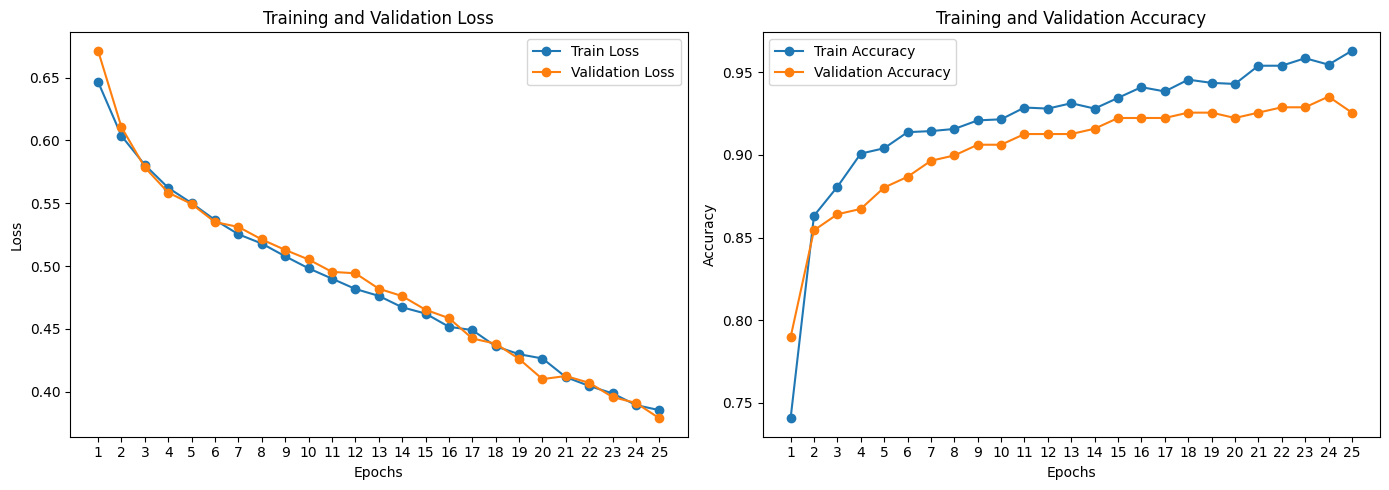

Training Time: 2874.55 seconds


In [15]:
def decode_tokens(token_ids):
    return tokenizer.decode(token_ids, skip_special_tokens=True)

# Hasil training dan validasi
model_Kesehatan = modelling_process(train_loader_Kesehatan, val_loader_Kesehatan, 25, 0.00001, 'Kesehatan_64_0.2')

Accuracy: 0.9256
Precision: 0.8851
Recall: 0.9809
F1-Score: 0.9305


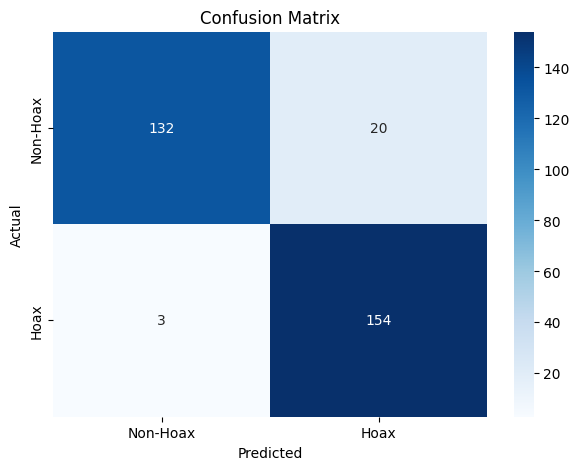


False Negatives (FN):
screening kesehatan wajib bpjs bantu produsen vaksin meneliti efek kerusakan akibat vaksin assalamualaikum salam sehat menginformasikan screening bpjs kesehatan yg bersifat wajib jumat juli peserta bpjs periksa wajib skrining kesehatan peserta skrining kesehatan pemeriksaan kesehatan fasyankes muncul notifikasi pasien skrining monggo yg mengisi silakan langsung diisi keluarganya putra putri yg berusia th mengakses pelayanan puskesmas klinik lancar tdk kendala krn skrining kesehatan mohon bantuan warga masyarakat warga pengisian wajib screening bpjs kesehatan link webskrining bpjs kesehatan go id
tulisan kawan kawan komunitas idi ikatan dokter indonesia tulisannya bagus ilmiah termakan pembodohan berpikirlah akal sehat sehat tubuhnya terang paham hakekatnya udara didunia bersih sehat pandemi covid virus berterbangan mematikan bentuk pengelabuan pembodohan global yg berani bicara kebenaran kirimkan dr yusrita tulisan komunitas idi ikatan dokter indonesia tulisannya

In [16]:
evaluate_model(model_Kesehatan, tokenizer, 'Kesehatan_64_0.2')

## Uji pada Test data

In [17]:
# Load State dict
state_dict = torch.load('indobert_lstm_modelKesehatan_64_0.2.pth')
model.load_state_dict(state_dict)
model.eval()  # Set model to evaluation mode

IndoBERT_LSTM(
  (indobert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [18]:
def evaluate_test(model, data_loader, criterion, name_file, tokenizer):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    total_preds = []
    total_labels = []

    false_negatives = []
    false_positives = []

    with torch.no_grad():
        for batch in data_loader:
            # Batch is a list with format [input_ids, attention_mask, labels]
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device).squeeze(1)  # Squeeze to change shape from (32, 1) to (32,)

            # Forward pass
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            preds = torch.argmax(logits, dim=1)

            # Update metrics
            epoch_loss += loss.item()
            epoch_acc += (preds == labels).sum().item()
            total_preds.extend(preds.cpu().numpy())
            total_labels.extend(labels.cpu().numpy())

            # Identify false negatives and false positives
            for i in range(len(labels)):
                text = tokenizer.decode(input_ids[i].cpu().tolist(), skip_special_tokens=True)
                if preds[i] == 0 and labels[i] == 1:  # False Negative
                    false_negatives.append((text, labels[i].cpu().numpy(), preds[i].cpu().numpy()))
                elif preds[i] == 1 and labels[i] == 0:  # False Positive
                    false_positives.append((text, labels[i].cpu().numpy(), preds[i].cpu().numpy()))

    # Compute average loss and accuracy
    avg_loss = epoch_loss / len(data_loader)
    avg_acc = epoch_acc / len(total_labels)

    # Compute confusion matrix
    cm = confusion_matrix(total_labels, total_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    tick_labels = ['Non-Hoax', 'Hoax']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tick_labels, yticklabels=tick_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute evaluation metrics
    accuracy = accuracy_score(total_labels, total_preds)
    precision = precision_score(total_labels, total_preds)
    recall = recall_score(total_labels, total_preds)
    f1 = f1_score(total_labels, total_preds)

    print(f'Test Loss: {avg_loss:.3f}')
    print(f'Test Accuracy: {avg_acc*100:.2f}%')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    # Save false negatives and false positives to CSV
    df_fn = pd.DataFrame(false_negatives, columns=['narasi', 'true_label', 'predicted_label'])
    df_fp = pd.DataFrame(false_positives, columns=['narasi', 'true_label', 'predicted_label'])
    df_fn.to_csv(f'false_negatives{name_file}.csv', index=False)
    df_fp.to_csv(f'false_positives{name_file}.csv', index=False)
    
    return avg_loss, avg_acc

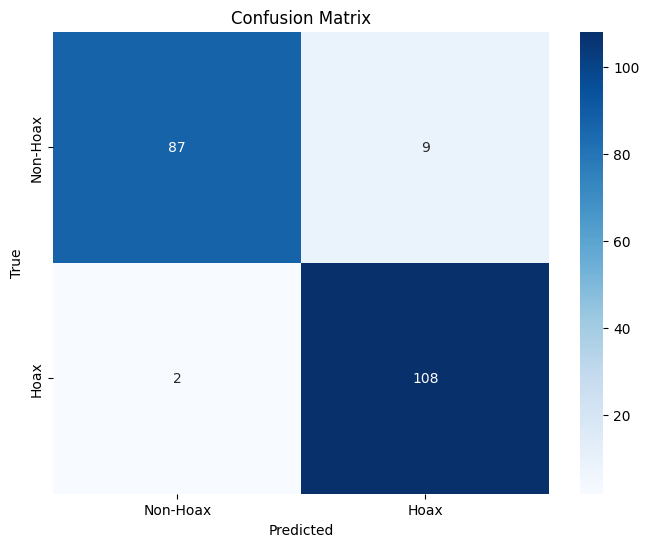

Test Loss: 0.354
Test Accuracy: 94.66%
Accuracy: 0.9466
Precision: 0.9231
Recall: 0.9818
F1 Score: 0.9515


In [19]:
criterion = nn.CrossEntropyLoss()

test_loss, test_acc = evaluate_test(model, test_loader_Kesehatan, criterion, '0.2_64_Kesehatan', tokenizer)

In [20]:
torch.cuda.empty_cache()